In [1]:
from get_file_matches import get_tif_file_matches, get_als_tif_matches
from preprocess_and_stack import stack_and_save

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import rasterio
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os

In [2]:
def load_raster_data(file_path):
    with rasterio.open(file_path) as src:
        data = src.read()
    return np.moveaxis(data, 0, -1)  # Move channel axis to the end

def load_data(matches, resize_shape=(256, 256)):
    X, Y = [], []
    for stacked_tif, ground_truth_tif in matches.items():
        # Load stacked TIF and ground truth mask
        stacked = load_raster_data(stacked_tif)
        ground_truth = load_raster_data(ground_truth_tif)[..., 0]  # Use the first channel
        
        # Resize to consistent shape
        stacked = tf.image.resize(stacked, resize_shape).numpy()
        ground_truth = tf.image.resize(ground_truth[..., np.newaxis], resize_shape).numpy()
        
        X.append(stacked)
        Y.append(ground_truth)
    
    return np.array(X), np.array(Y)


def build_unet(input_shape):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    return models.Model(inputs, outputs)


def visualize_prediction(model, X, Y):
    """
    Visualize predictions for the segmentation task.

    Parameters:
    - model: Trained segmentation model.
    - X: Input data (stacked raster).
    - Y: Ground truth masks.
    """
    pred = model.predict(X)
    for i in range(len(X)):
        plt.figure(figsize=(15, 5))
        
        # Plot the input (first three bands as RGB)
        plt.subplot(1, 3, 1)
        plt.title("Input (First 3 Bands)")
        plt.imshow(X[i, :, :, :3])  # Display the first 3 bands as an RGB image
        
        # Plot the ground truth
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(Y[i].squeeze(), cmap='gray')  # Ground truth mask
        
        # Plot the prediction
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(pred[i].squeeze(), cmap='gray')  # Predicted mask
        
        plt.show()

def evaluate_predictions(model, X, Y, threshold=0.5):
    """
    Evaluate predictions of the segmentation model using IoU, Dice, Accuracy, Precision, and Recall.
    
    Parameters:
    - model: Trained segmentation model.
    - X: Input images (stacked raster).
    - Y: Ground truth masks.
    - threshold: Threshold to binarize predicted mask (default = 0.5).
    
    Returns:
    - metrics: Dictionary containing evaluation metrics (IoU, Dice, Accuracy, Precision, Recall).
    """
    metrics = {'IoU': [], 'Dice': [], 'Accuracy': [], 'Precision': [], 'Recall': []}
    
    # Generate predictions for X
    predictions = model.predict(X)
    predictions = (predictions > threshold).astype(np.uint8)  # Binarize predictions
    
    for i in range(len(X)):
        y_true = Y[i].squeeze().flatten()
        y_pred = predictions[i].squeeze().flatten()
        
        iou = jaccard_score(y_true, y_pred)
        dice = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=1)
        recall = recall_score(y_true, y_pred, zero_division=1)
        
        metrics['IoU'].append(iou)
        metrics['Dice'].append(dice)
        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
    
    # Calculate the mean of all metrics
    mean_metrics = {key: np.mean(values) for key, values in metrics.items()}
    print("\n==== Model Evaluation Metrics ====")
    for metric, value in mean_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics, mean_metrics

In [3]:
als_folder = "data/Tschernitz/als"
dop_folder = "data/Tschernitz/dop"
output_base_dir = "data/Tschernitz/output"

#stack_and_save(als_folder, dop_folder, output_base_dir) --stacks dop images with chm and slope maps

Folder1 Path: data/Tschernitz\dop
Folder2 Path: data/Tschernitz\ground_truth_masks/tree_masks
Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4603 - loss: 0.6975 - val_accuracy: 0.3804 - val_loss: 0.6932
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4573 - loss: 0.6919 - val_accuracy: 0.6230 - val_loss: 0.6860
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5841 - loss: 0.6913 - val_accuracy: 0.7517 - val_loss: 0.6822
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7207 - loss: 0.6823 - val_accuracy: 0.7445 - val_loss: 0.6700
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7108 - loss: 0.6724 - val_accuracy: 0.7474 - val_loss: 0.6510
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7167 - loss: 0.6514 - val_accuracy: 0.7544 - val_loss: 0.6056
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7248 - loss: 0.6172 - val_accuracy: 0.7430 - val_loss: 0.5578
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/ste

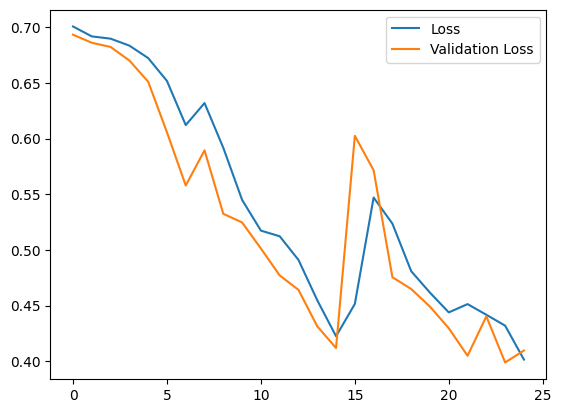

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


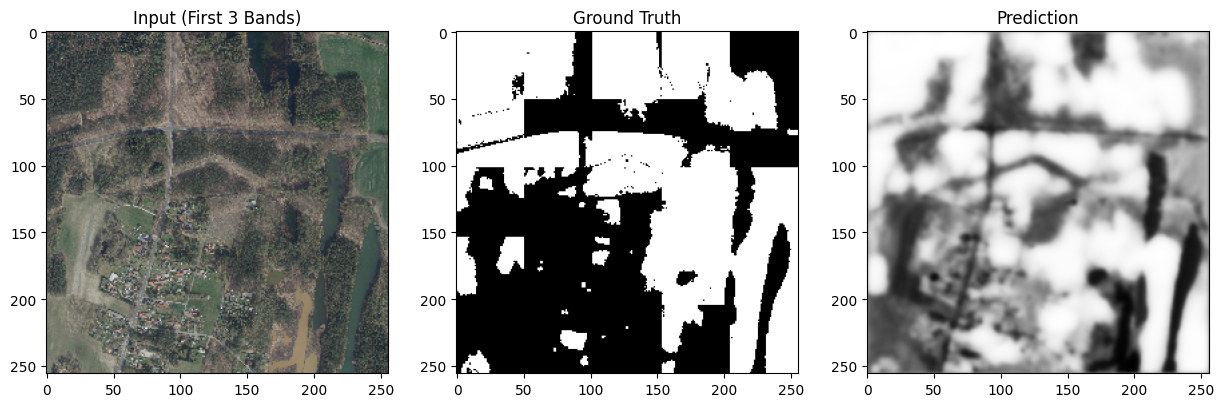

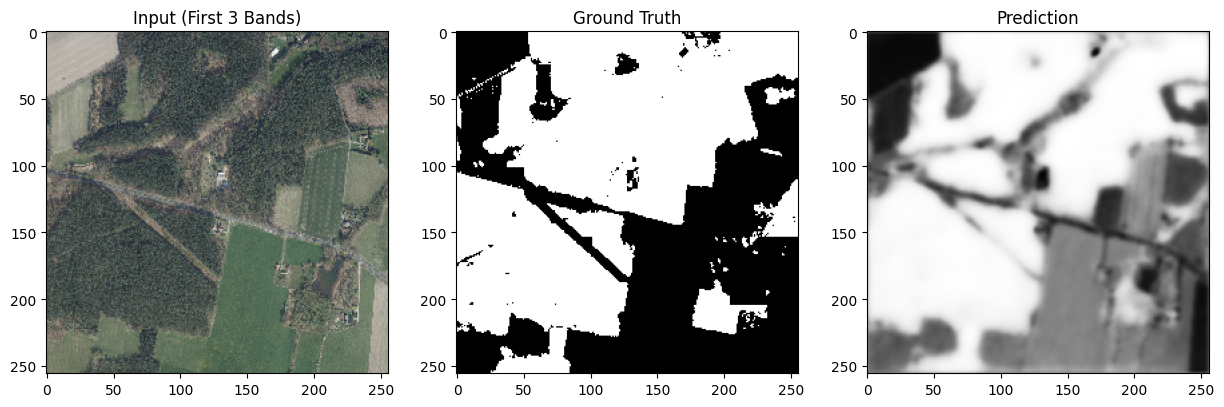

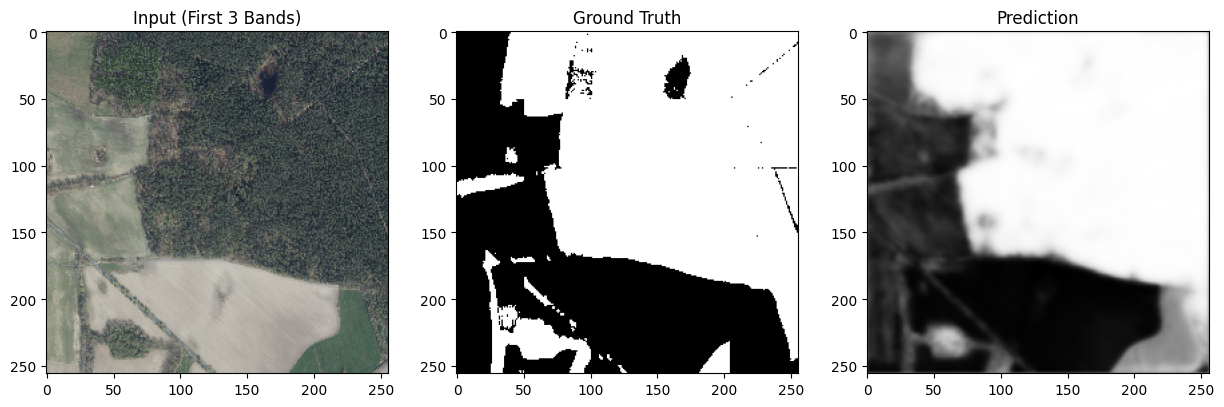

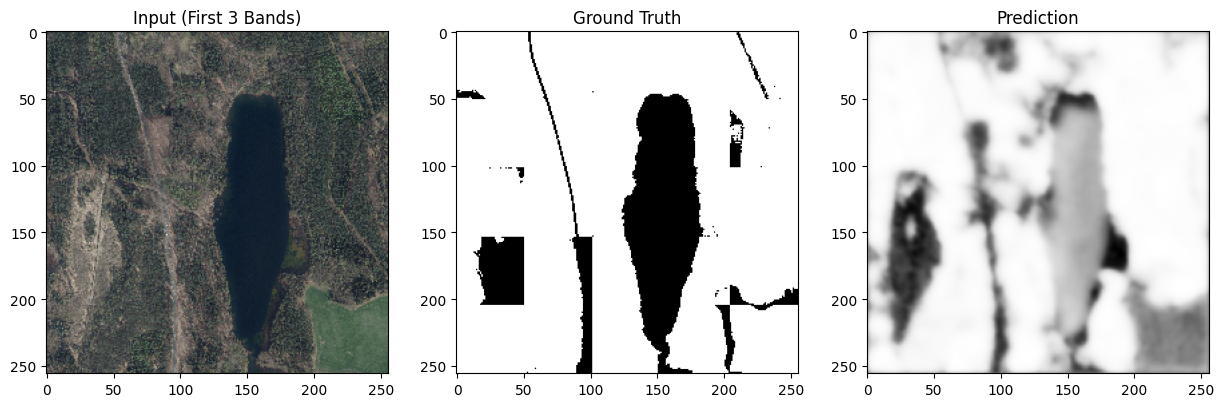

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step

==== Model Evaluation Metrics ====
IoU: 0.7336
Dice: 0.8420
Accuracy: 0.7878
Precision: 0.7734
Recall: 0.9340


In [8]:

root_dir = "data/Tschernitz"
folder1 = "dop"
folder2 = "ground_truth_masks/tree_masks"

# Match stacked TIF and ground truth mask
matches = get_tif_file_matches(root_dir, folder1, folder2, contains2="merged")
X, Y = load_data(matches)

# Normalize inputs and binarize ground truth masks
X = X / 255.0
Y = (Y > 0).astype(np.float32)

# Split into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
# Train the Model
input_shape = X_train.shape[1:]
unet_model_no_aug = build_unet(input_shape)
unet_model_no_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_no_aug = unet_model_no_aug.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=25
)

# Step 5: Visualize Training
plt.plot(history_no_aug.history['loss'], label='Loss')
plt.plot(history_no_aug.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

visualize_prediction(unet_model_no_aug, X_val, Y_val)
metrics_no_aug, mean_metrics_no_aug = evaluate_predictions(unet_model_no_aug, X_val, Y_val, threshold=0.5)


Folder1 Path: data/Tschernitz\output
Folder2 Path: data/Tschernitz\ground_truth_masks/tree_masks
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 817ms/step - accuracy: 0.5191 - loss: 0.6972 - val_accuracy: 0.3826 - val_loss: 0.6901
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 786ms/step - accuracy: 0.6150 - loss: 0.6834 - val_accuracy: 0.6770 - val_loss: 0.6676
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 773ms/step - accuracy: 0.6767 - loss: 0.6629 - val_accuracy: 0.7752 - val_loss: 0.6264
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 783ms/step - accuracy: 0.7369 - loss: 0.6370 - val_accuracy: 0.7092 - val_loss: 0.5700
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 808ms/step - accuracy: 0.6678 - loss: 0.6511 - val_accuracy: 0.7934 - val_loss: 0.5153
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 801ms/step - accuracy: 0.8348 - loss: 0.4642 - val_accuracy: 0.7893 - val_loss: 0.4167
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step - accuracy: 0.8256 - loss: 0.4064 - val_accuracy: 0.8391 - val_loss: 0.3747
Epoch 8/25
4/4 ━━━━━━

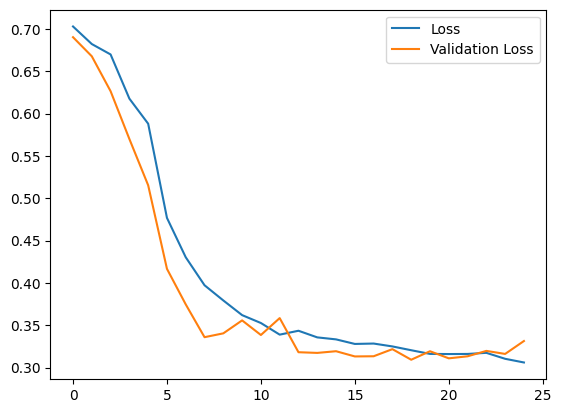

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


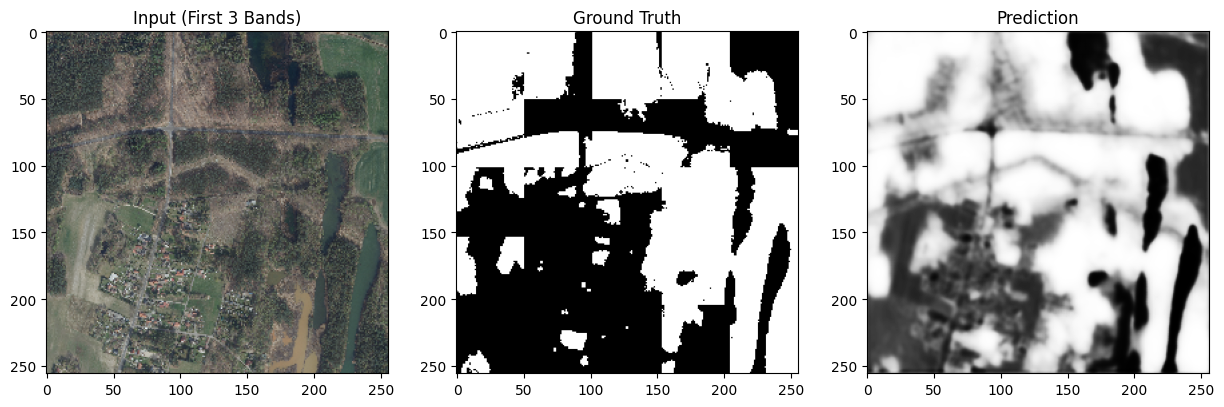

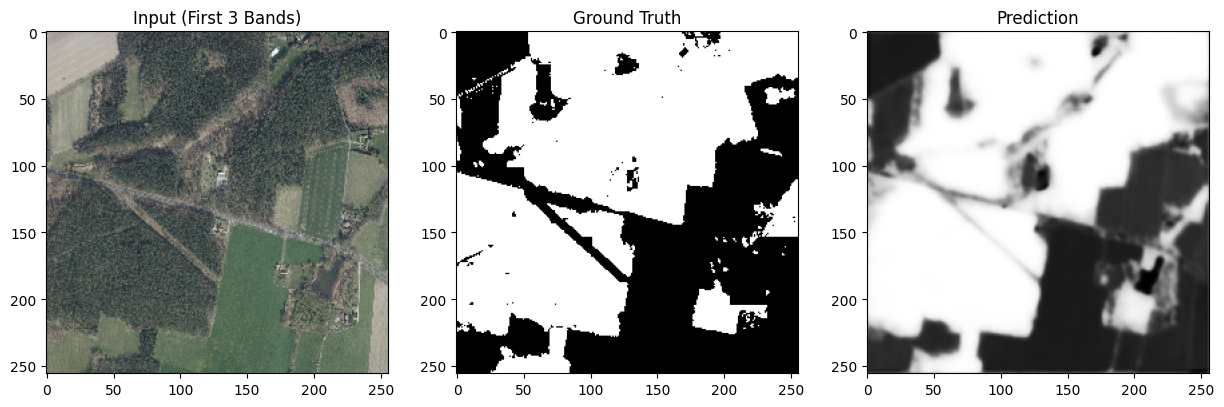

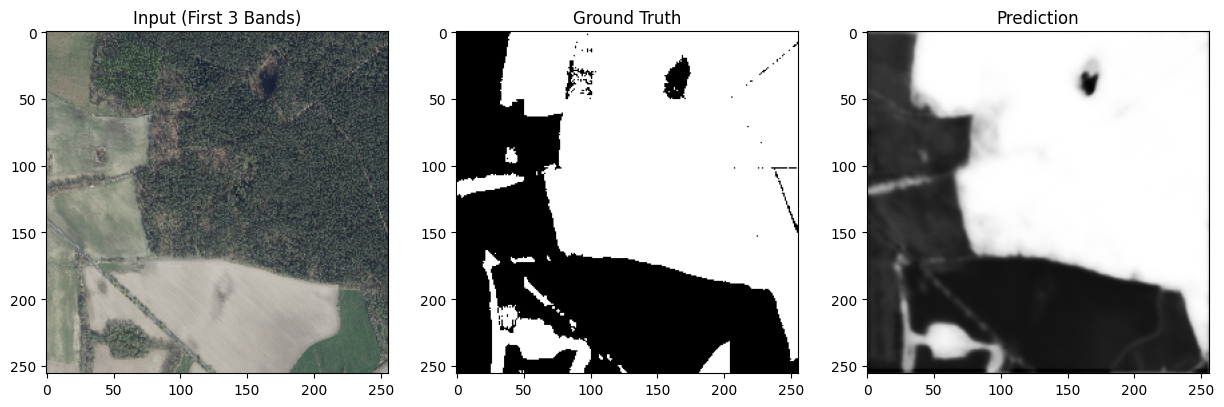

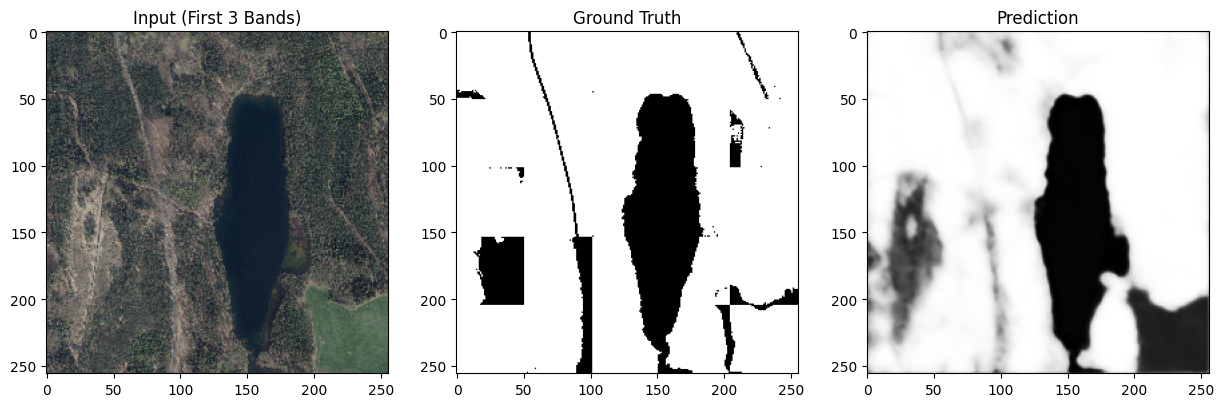

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step

==== Model Evaluation Metrics ====
IoU: 0.8191
Dice: 0.8967
Accuracy: 0.8718
Precision: 0.8726
Recall: 0.9284


In [5]:
root_dir = "data/Tschernitz"
folder1 = "output"
folder2 = "ground_truth_masks/tree_masks"

# Match stacked TIF and ground truth mask
matches = get_tif_file_matches(root_dir, folder1, folder2, contains1='final_input',contains2="merged")
X, Y = load_data(matches)

# Normalize inputs and binarize ground truth masks
X = X / 255.0
Y = (Y > 0).astype(np.float32)

# Split into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
# Train the Model
input_shape = X_train.shape[1:]
unet_model_no_aug = build_unet(input_shape)
unet_model_no_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_no_aug = unet_model_no_aug.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=4,
    epochs=25
)

# Step 5: Visualize Training
plt.plot(history_no_aug.history['loss'], label='Loss')
plt.plot(history_no_aug.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

visualize_prediction(unet_model_no_aug, X_val, Y_val)
metrics_no_aug, mean_metrics_no_aug = evaluate_predictions(unet_model_no_aug, X_val, Y_val, threshold=0.5)


Epoch 1/25


c:\Users\aylin\anaconda3\envs\geo\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4939 - loss: 0.6967 - val_accuracy: 0.6257 - val_loss: 0.6696
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6393 - loss: 0.6811 - val_accuracy: 0.7159 - val_loss: 0.6479
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6810 - loss: 0.6373 - val_accuracy: 0.7470 - val_loss: 0.5792
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7235 - loss: 0.5796 - val_accuracy: 0.7668 - val_loss: 0.4938
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7739 - loss: 0.4888 - val_accuracy: 0.8082 - val_loss: 0.4398
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8156 - loss: 0.4524 - val_accuracy: 0.8320 - val_loss: 0.4113
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8467 - loss: 0.3878 - val_accuracy: 0.8360 - val_loss: 0.3526
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8577 - loss: 0.3449 - val_accuracy: 0.8646 - val_loss: 0.3239
Epoch 9/25
6/6 ━━━━━━━━━━

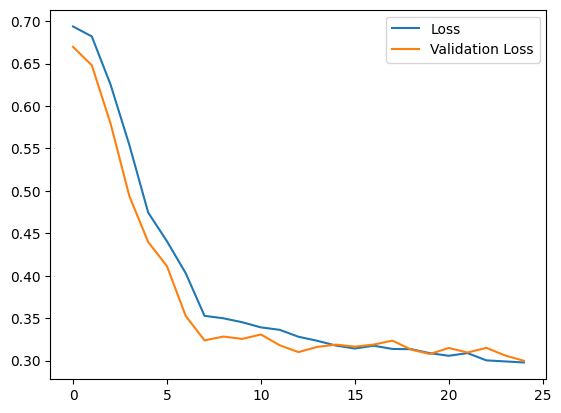

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


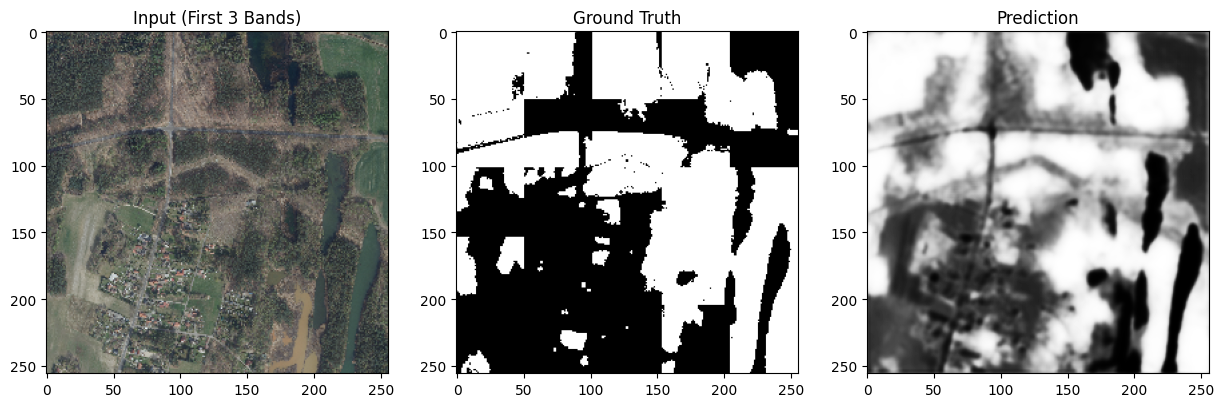

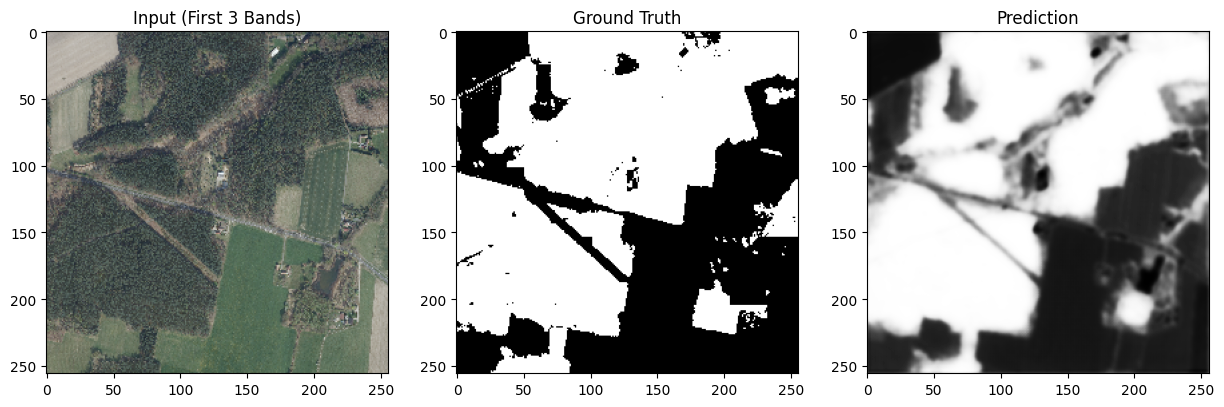

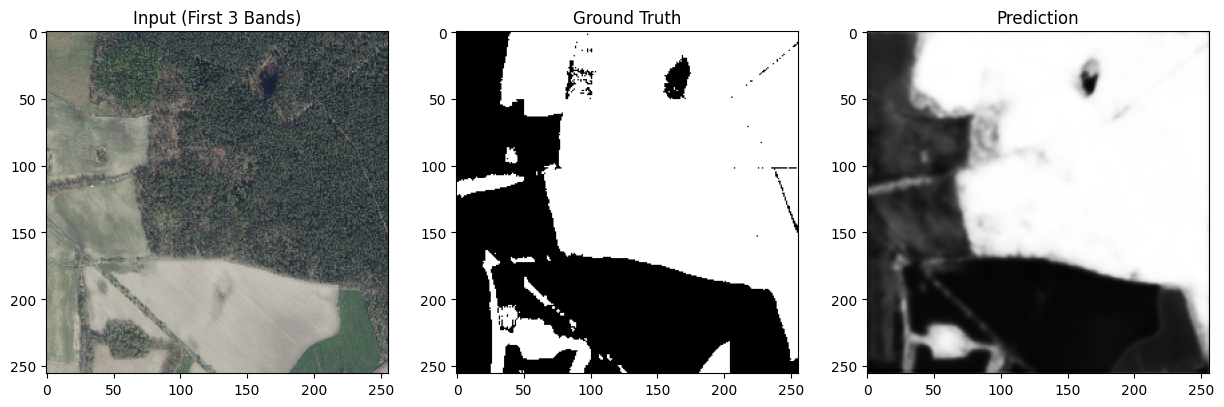

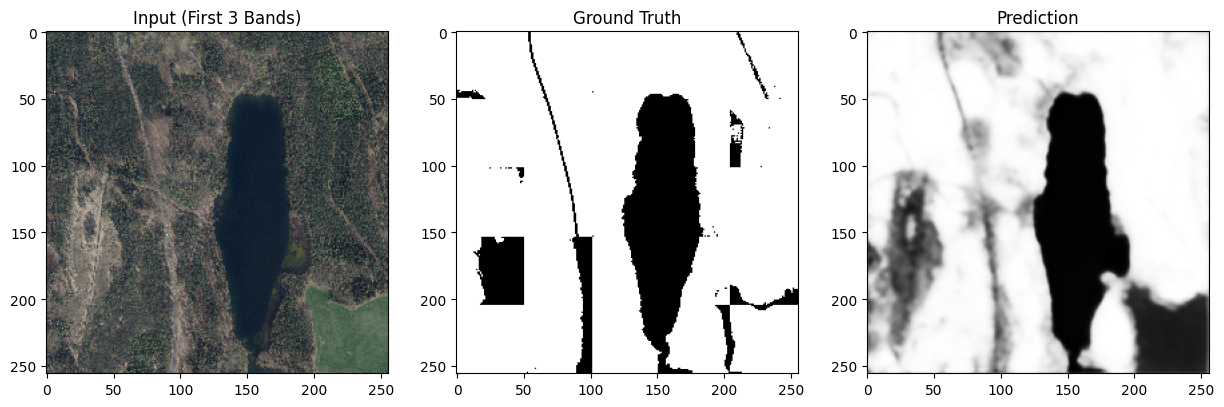

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step

==== Model Evaluation Metrics ====
IoU: 0.8231
Dice: 0.9000
Accuracy: 0.8811
Precision: 0.9008
Recall: 0.9012


In [6]:
from albumentations import Compose, RandomRotate90, HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, GaussNoise

# Targeted augmentation pipeline
def get_augmentation_pipeline():
    return Compose([
        RandomRotate90(p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.05, rotate_limit=15, p=0.5),
        #RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        #GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    ])

# Apply augmentation
def augment_dataset(X, Y, num_versions=3):
    augmentation_pipeline = get_augmentation_pipeline()
    X_aug, Y_aug = [], []
    for i in range(len(X)):
        for _ in range(num_versions):
            augmented = augmentation_pipeline(image=X[i], mask=Y[i])
            X_aug.append(augmented['image'])
            Y_aug.append(augmented['mask'])
    return np.array(X_aug), np.array(Y_aug)


# Apply targeted augmentation
X_train_aug, Y_train_aug = augment_dataset(X_train, Y_train)


# Train the model with the augmented data
input_shape = X_train_aug.shape[1:]
unet_model_refined_aug = build_unet(input_shape)
unet_model_refined_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_refined_aug = unet_model_refined_aug.fit(
    X_train_aug, Y_train_aug,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=25
)
#  Visualize Results
plt.plot(history_refined_aug.history['loss'], label='Loss')
plt.plot(history_refined_aug.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Visualize refined augmentation predictions
visualize_prediction(unet_model_refined_aug, X_val, Y_val)
metrics_refined_aug, mean_metrics_refined_aug = evaluate_predictions(unet_model_refined_aug, X_val, Y_val, threshold=0.5)

In [7]:
# Evaluate the models
metrics_no_aug, mean_metrics_no_aug = evaluate_predictions(unet_model_no_aug, X_val, Y_val, threshold=0.5)
metrics_aug, mean_metrics_aug = evaluate_predictions(unet_model_refined_aug, X_val, Y_val, threshold=0.5)
# Compare Metrics
print("\n==== Comparison of Metrics ====")
print(f"Without Augmentation: {mean_metrics_no_aug}")
print(f"With Augmentation: {mean_metrics_aug}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step

==== Model Evaluation Metrics ====
IoU: 0.8191
Dice: 0.8967
Accuracy: 0.8718
Precision: 0.8726
Recall: 0.9284
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step

==== Model Evaluation Metrics ====
IoU: 0.8231
Dice: 0.9000
Accuracy: 0.8811
Precision: 0.9008
Recall: 0.9012

==== Comparison of Metrics ====
Without Augmentation: {'IoU': np.float64(0.819101352149248), 'Dice': np.float64(0.8967213191223689), 'Accuracy': np.float64(0.8718109130859375), 'Precision': np.float64(0.872616365057321), 'Recall': np.float64(0.9284263606697307)}
With Augmentation: {'IoU': np.float64(0.823093578133812), 'Dice': np.float64(0.8999724977113769), 'Accuracy': np.float64(0.8811149597167969), 'Precision': np.float64(0.9008341190966126), 'Recall': np.float64(0.9011686822650726)}
